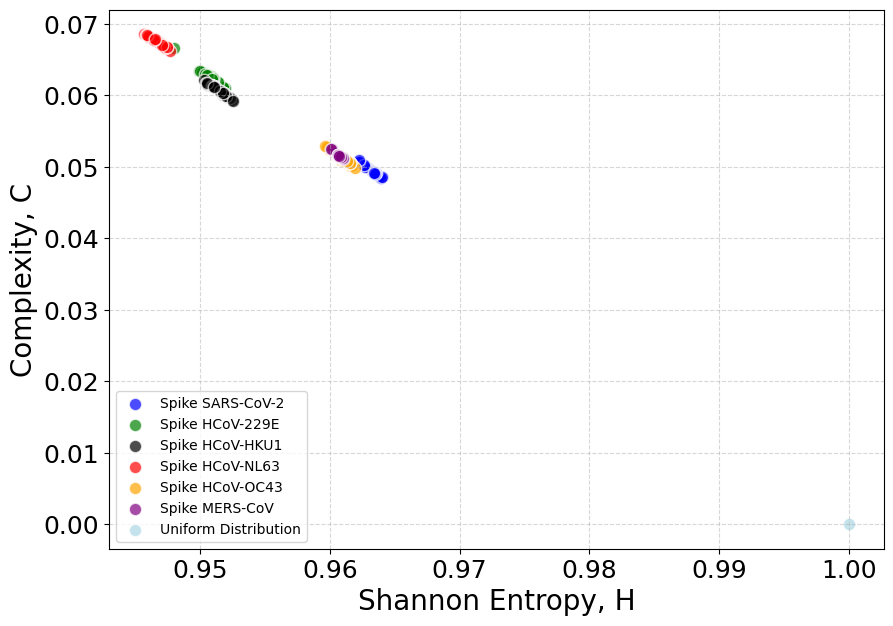

In [7]:
# Importation of essential libraries
import math  # Imports the math module for mathematical operations
import warnings  # Imports warnings to display or suppress messages
import numpy as np  # Imports NumPy for array manipulation and numerical calculations
import pandas as pd  # Imports Pandas for data table manipulation
import matplotlib.pyplot as plt  # Imports Matplotlib for generating graphs

# Defines the function `shannon_entropy`, which computes the Shannon entropy of a probability distribution
def shanonn_entropy(data, k, normalized=True):
    """
    Computes Shannon entropy for a given set of probabilities.

    Parameters:
    - data: array-like, list of probabilities.
    - k: int, total number of possible states.
    - normalized: bool, if True, normalizes entropy in the range [0,1].

    Returns:
    - Shannon entropy (normalized or not).
    """
    
    # Converts input data into a NumPy array with float64 type for higher precision
    probabilities = np.asarray(data, dtype=np.float64)

    # Removes zero probabilities to avoid log(0) errors, which are undefined
    probabilities = probabilities[probabilities > 0]

    # Computes Shannon entropy using the formula:
    # H = - Σ p_i * log2(p_i), where p_i are the probabilities of the distribution
    s = -np.sum(probabilities * np.log2(probabilities))

    if normalized:  # Checks if entropy should be normalized within the range [0,1]
        smax = np.log2(float(k))  # Computes the maximum possible entropy for normalization (log2(k))
        return s / smax  # Returns normalized entropy, ensuring values remain in the range [0,1]
    else:
        return s  # Returns entropy without normalization

# Function to compute complexity-entropy based on Jensen-Shannon divergence
def complexity_entropy(data, k):
    """
    Computes Shannon entropy and the associated complexity using Jensen-Shannon divergence.

    Parameters:
    - data: array-like, list of probabilities.
    - k: int, total number of possible states.

    Returns:
    - h: normalized Shannon entropy.
    - complexity: complexity based on Jensen-Shannon divergence.
    """

    n = float(k)  # Defines the total number of possible states, ensuring precision in calculations.

    probabilities = np.asarray(data, dtype=np.float64)  # Converts data into a double-precision NumPy array.
    probabilities = probabilities[probabilities > 0]  # Removes zero values to avoid logarithm errors.

    h = shanonn_entropy(probabilities, k)  # Computes the normalized Shannon entropy.

    n_states_not_occuring = n - len(probabilities)  # Counts how many states did not occur in the distribution.
    uniform_dist = 1 / n  # Defines the uniform distribution for comparison.

    # Computes the average distribution between the original and uniform distributions.
    p_plus_u_over_2 = (uniform_dist + probabilities) / 2

    # Computes the entropy of the average distribution (mixture of the real and uniform distributions).
    s_of_p_plus_u_over_2 = (
        -np.sum(p_plus_u_over_2 * np.log2(p_plus_u_over_2))  # Main term
        - (0.5 * uniform_dist) * np.log2(0.5 * uniform_dist) * n_states_not_occuring  # Correction for unobserved states
    )

    # Computes the entropy of the original distribution divided by 2.
    s_of_p_over_2 = -np.sum(probabilities * np.log2(probabilities)) / 2

    # Computes the entropy of the uniform distribution divided by 2.
    s_of_u_over_2 = np.log2(n) / 2.0

    # Computes the theoretical maximum Jensen-Shannon divergence.
    js_div_max = -0.5 * (
        ((n + 1) / n) * np.log2(n + 1) + np.log2(n) - 2 * np.log2(2 * n)
    )

    # Computes the Jensen-Shannon divergence of the original distribution relative to the uniform distribution.
    js_div = s_of_p_plus_u_over_2 - s_of_p_over_2 - s_of_u_over_2

    # Returns Shannon entropy and normalized complexity.
    return h, h * js_div / js_div_max

# List of Excel files containing probability distributions for each species
dist_prob_species = [
    "probabilities_Spike SARS-CoV-2.xlsx",
    "probabilities_Spike HCoV-229E.xlsx",
    "probabilities_Spike HCoV-HKU1.xlsx",
    "probabilities_Spike HCoV-NL63.xlsx",
    "probabilities_Spike HCoV-OC43.xlsx",
    "probabilities_Spike MERS-CoV.xlsx",
    "probabilities_Uniform Distribution.xlsx"  # Uniform distribution for comparison
]

# Define different colors for each file in the graph
colors = ['blue', 'green', 'black', 'red', 'orange', 'purple', 'lightblue', 'pink']

# Set the figure size for the graph
plt.figure(figsize=(10, 7))

# Loop through each Excel file to process the data and generate the graphs
for i, file in enumerate(dist_prob_species):
    entropies = []  # List to store Shannon entropy values
    complexities = []  # List to store complexity values

    try:
        df = pd.read_excel(file)  # Reads the data from the Excel file and stores it in a Pandas DataFrame.

        # Check if the 'Sequence_ID' column exists in the DataFrame. Otherwise, raise an error.
        if "Sequence_ID" not in df.columns:
            raise KeyError(f"The column 'Sequence_ID' was not found in the file {file}")

        # Select the columns representing k-mer frequencies (ignoring 'Sequence_ID')
        kmer_columns = df.columns[1:]

        # Iterate through each row of the DataFrame (each sequence/protein)
        for index, row in df.iterrows():
            # Get the k-mer frequency values
            p = row[kmer_columns].tolist()

            # Check if the probabilities sum approximately to 1.0 (normalization)
            if not np.isclose(sum(p), 1.0):
                print(f"Warning: The sum of probabilities in row {index} of file '{file}' is not equal to 1.0. Skipping this row.")
                continue  # Skip the row if the probabilities are not normalized

            try:
                # Compute entropy and complexity based on Jensen-Shannon divergence
                entropy, complexity = complexity_entropy(p, k=20)

                # Store the results
                entropies.append(entropy)
                complexities.append(complexity)
            except ValueError as e:
                print(f"Error unpacking the result: {e}")
            except Exception as e:
                print(f"Error computing entropy and complexity: {e}")

        # Plot the Entropy vs Complexity points for each Excel file
        plt.scatter(entropies, complexities, color=colors[i % len(colors)], s=80, alpha=0.7, edgecolor='white',
                    label=file.replace('probabilities_', '').replace('.xlsx', ''))

    except FileNotFoundError:
        print(f"Error: The file '{file}' was not found. Check the file path and name.")
    except KeyError as e:
        print(e)

# Final graph configuration
plt.xticks(fontsize=18)  # Set the font size for X-axis values
plt.yticks(fontsize=18)  # Set the font size for Y-axis values
plt.xlabel("Shannon Entropy, H", fontsize=20)  # Set the label for the X-axis
plt.ylabel("Complexity, C", fontsize=20)  # Set the label for the Y-axis
plt.grid(True, linestyle='--', alpha=0.5)  # Add a dashed grid to the graph for better visualization
plt.legend(fontsize=10, loc='lower left')  # Add a legend to differentiate each file in the graph

# Save the generated graph as an image file
plt.savefig('Shannon complexity-entropy graph (Amino Acids).png')

# Display the generated graph
plt.show()
